In [ ]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb

    path_andrey = '/Home/siv30/wad005/master/GRB/MATLAB/andrey_mezentsev/'

else:
    %run /Users/andreas/fun/useful_py_func/matplotlib_custom_style_and_macros.py
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
    path_andrey = '/Users/andreas/phys/master/GRB/MATLAB/andrey_mezentsev/'
    
from stingray import Lightcurve as LC
from stingray import CrossCorrelation as CC
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['text.usetex'] = False
plt.rcParams['figure.figsize'] = [12, 8]

# Function

In [109]:
import numpy as np
from numpy.polynomial.polynomial import polyval,polyfit
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def estimate_duration(GRB_id=None, binsize=None, tlagg_asim=None, T0=None, bak_interval=None, poly_degree=0, mean_start_time=None, info_text=None, export=False):
    """
    Calculate the T90 duration of a given Gamma-Ray Burst (GRB).

    Parameters:
    GRB_id (str): The identification of the GRB.
    binsize (float): The size of the bins for the histogram.
    tlagg_asim (float): The time lag given in seconds.
    T0 (str): The initial time in ISO format.
    bak_interval (list of tuples): The intervals for the background estimation.
    poly_degree (int, optional): The degree of the polynomial for the background fit. Defaults to 0.
    mean_start_time (float): The time at which the mean of the cumulative counts is estimated. Defaults to None
    info_text (str, optional): Information regarding the T90 estimation. Printed in the exported PDF.
    export (bool): Exporting info_text and figures to a PDF file. Defaults to False.

    Returns:
    float: The T90 duration of the GRB.
    PDF: If export parameter is True and info_text is provided.
    """
    
    # Check if all necessary parameters are provided
    if not all([GRB_id!=None, binsize!=None, tlagg_asim!=None, T0!=None, bak_interval!=None]):
        raise ValueError("All parameters must be provided.")
   
    # Load data
    asimData = pd.read_csv(f'{path_andrey}{GRB_id}.csv')
    asimData['tus'] /= 1e6
    asimData['tus'] += tlagg_asim
    asimData.sort_values(by=['tus'],inplace=True,ignore_index=True)
    tus_asim = asimData['tus'].to_numpy()

    # Calculate T0
    T0 = datetime.fromisoformat(T0) + timedelta(seconds=tlagg_asim)
    print(f'T0 {T0}, applied time lagg: {np.round(tlagg_asim,5)} s')

    # Create histogram
    grb_hist = np.histogram(tus_asim, np.arange(tus_asim[0], tus_asim[-1] + binsize, binsize))
    grb_counts, grb_edges = grb_hist[0], grb_hist[1]

    # Initialize background level array
    background_level = np.zeros_like(grb_counts) #returning array of zeros in the same shape as grb_counts

    # Calculate background level for each interval
    # Create a boolean array for the background mask
    bak_mask = np.zeros_like(grb_counts, dtype=bool)
    for interval in bak_interval:
        ti_bkg, tf_bkg = interval
        interval_mask = (grb_edges[:-1] >= ti_bkg) & (grb_edges[:-1] < tf_bkg)
        bak_mask = np.logical_or(bak_mask, interval_mask)

    # Use polynomial of n-th degree to fit the background level
    polyCoefs = polyfit(grb_edges[:-1][bak_mask], grb_counts[bak_mask], poly_degree)
    print(f"poly: {polyCoefs}")
    # Calculate the background level for the entire light curve array using the fitted polynomial
    background_level = polyval(grb_edges[:-1], polyCoefs)

    # Subtract background
    background_subtracted = grb_counts - background_level

    # Calculate cumulative sum of background subtracted counts
    cumulative_counts = np.cumsum(background_subtracted)
    
    # Finding start index for start of calculating the mean of the total cumulative counts; inserted to the left (a[i-1] < t <= a[i])
    index_cumulative_start = np.searchsorted(grb_edges[:-1], mean_start_time)

    # Calculate the mean of the total cumulative counts
    total_counts = np.mean(cumulative_counts[index_cumulative_start:])

    # Calculate T90
    # Find the first index where cumulative counts reach or exceed 5% of total counts
    t1_90_index = np.argmax(cumulative_counts >= 0.05 * total_counts)
    t1_90 = grb_edges[t1_90_index]
    
    # Find the first index where cumulative counts reach or exceed 95% of total counts and do not dip below it afterward
    t2_90_index = np.argmax(cumulative_counts >= 0.95 * total_counts)
    t2_90 = grb_edges[t2_90_index] 
    
    # Calculate T90 duration
    T90 = t2_90 - t1_90

    # Calculate T50
    # Find the first index where cumulative counts reach or exceed 25% of total counts
    t1_50_index = np.argmax(cumulative_counts >= 0.25 * total_counts)
    t1_50 = grb_edges[t1_50_index]

    # Find the first index where cumulative counts reach or exceed 75% of total counts and do not dip below it afterward
    t2_50_index = np.argmax(cumulative_counts >= 0.75 * total_counts)
    t2_50 = grb_edges[t2_50_index]

    # Calculate T50 duration
    T50 = t2_50 - t1_50
    
    if export != False and info_text != None:
        # Create a new PDF file
        pdf_pages = PdfPages(f'{GRB_id}_T90report.pdf')
        
        # Create a blank figure for the text
        fig0 = plt.figure(figsize=(11, 8))
        plt.axis('off')
        plt.text(0, 0, info_text, fontsize=12)
        pdf_pages.savefig(fig0)

        # Save figures to the PDF
        
        # Figure 1: Light Curve
        fig1 = plt.figure(figsize=(11, 8))
        plt.step(grb_edges[:-1], grb_counts, color='black')
        plt.title(f'Light Curve for {GRB_id}')
        plt.xlabel('Time from T0 (s)')
        plt.ylabel(f'Counts per {format(binsize*1000, ".0f")} ms')
        plt.plot(grb_edges[:-1][bak_mask], background_level[bak_mask], color='blue', linestyle='-', label='Background Level')
        for interval in bak_interval:
            plt.axvline(x=interval[0], ymin=0, ymax=0.68, color='g', linestyle='--')
            plt.axvline(x=interval[1], ymin=0, ymax=0.68, color='r', linestyle='--')
        plt.legend()
        pdf_pages.savefig(fig1)

        # Figure 2: Background Subtracted Light Curve
        fig2 = plt.figure(figsize=(11, 8))
        plt.step(grb_edges[:-1], background_subtracted, color='black', where='post')
        plt.title(f'Background Subtracted Light Curve for {GRB_id}')
        plt.xlabel('T-T0 (s)')
        plt.ylabel(f'Counts per {format(binsize*1000, ".0f")} ms')
        for interval in bak_interval:
            plt.axvline(x=interval[0], ymin=0, ymax=0.68, color='g', linestyle='--')
            plt.axvline(x=interval[1], ymin=0, ymax=0.68, color='r', linestyle='--')
        plt.axhline(y=0, color='blue', linestyle='--', label='Background Level')
        plt.legend()
        pdf_pages.savefig(fig2)

        # Figure 3: Cumulative Counts
        fig3 = plt.figure(figsize=(11, 8))
        
        plt.title(f'Cumulative Counts for {GRB_id}')
        plt.xlabel('T-T0 (s)')
        plt.ylabel(f'Cumulative Counts per {format(binsize*1000, ".0f")} ms')
        
        plt.plot(grb_edges[:-1], cumulative_counts, color='black')
        plt.axhline(y=cumulative_counts[t1_90_index], color='g', linestyle='--', label='0.05%')
        plt.axhline(y=cumulative_counts[t1_50_index], color='cyan', linestyle='--', label='0.25%')
        plt.axhline(y=cumulative_counts[t2_50_index], color='purple', linestyle='--', label='0.75%')
        plt.axhline(y=cumulative_counts[t2_90_index], color='r', linestyle='--', label='0.95%')
        plt.axhline(y=total_counts, color='darkgray', linestyle='--', label='~100%')
        plt.axvline(x=grb_edges[index_cumulative_start], color='orange', linestyle='--', label='Start of mean total')
        plt.axhline(y=0, linestyle='--', color='black')
        plt.scatter(x=t1_90,y=cumulative_counts[t1_90_index],marker='o',s=40,c='g')
        plt.text(x=t1_90+0.05, y=cumulative_counts[t1_90_index]+1, s=f'({format(t1_90, ".3f")}, {format(cumulative_counts[t1_90_index], ".0f")})', fontsize=12)
        plt.text(x=t2_90-0.3, y=cumulative_counts[t2_90_index]+1, s=f'({format(t2_90, ".3f")}, {format(cumulative_counts[t2_90_index], ".0f")})', fontsize=12)
        plt.text(x=t1_50+0.05, y=cumulative_counts[t1_50_index]+1, s=f'({format(t1_50, ".3f")}, {format(cumulative_counts[t1_50_index], ".0f")})', fontsize=12)
        plt.text(x=t2_50+0.05, y=cumulative_counts[t2_50_index]+1, s=f'({format(t2_50, ".3f")}, {format(cumulative_counts[t2_50_index], ".0f")})', fontsize=12)

        plt.scatter(x=t2_90,y=cumulative_counts[t2_90_index],marker='o',s=40,c='r')
        plt.scatter(x=t1_50,y=cumulative_counts[t1_50_index],marker='o',s=40,c='cyan')
        plt.scatter(x=t2_50,y=cumulative_counts[t2_50_index],marker='o',s=40,c='purple')
        plt.scatter(x=grb_edges[index_cumulative_start],y=cumulative_counts[index_cumulative_start],marker='o',s=40,c='orange')
        plt.legend()
        pdf_pages.savefig(fig3)
        
        # Plot 4: Background Subtracted Light Curve with T90 Start & Stop
        fig4 = plt.figure(figsize=(11, 8))
        plt.step(grb_edges[:-1], background_subtracted, color='black', where='post')
        plt.title(f'{GRB_id} Background Subtracted Light Curve')
        plt.xlabel('T-T0 (s)')
        plt.ylabel(f'Counts per {format(binsize*1000, ".0f")} ms')
        plt.axvline(x=grb_edges[t1_50_index], color='cyan', linestyle='--',label='Start T50')
        plt.axvline(x=grb_edges[t1_90_index], color='g', linestyle='--',label='Start T90')
        plt.axvline(x=grb_edges[t2_50_index], color='purple', linestyle='--',label=f'T50: {format(T50, ".3f")} s')
        plt.axvline(x=grb_edges[t2_90_index], color='r', linestyle='--',label=f'T90: {format(T90, ".3f")} s')
        plt.axhline(y=0, color='blue', linestyle='--', label='Background Level')
        plt.legend()
        #plt.xlim(-0.5,0.5)
        pdf_pages.savefig(fig4)
        
        # Close the PDF file
        pdf_pages.close()
        
        return T90, T50, polyCoefs
    else:
        # Plotting without exporting

        # Plot 1: Light Curve
        print(f'Mean background level: {np.round(np.mean(background_level))} / {binsize} [counts/s]')
        plt.step(grb_edges[:-1], grb_counts, color='black')
        plt.title(f'Light Curve for {GRB_id}')
        plt.xlabel('Time from T0 (s)')
        plt.ylabel(f'Counts per {format(binsize*1000, ".0f")} ms')
        plt.plot(grb_edges[:-1][bak_mask], background_level[bak_mask], color='blue', linestyle='-', label='Background Level')
        for interval in bak_interval:
            plt.axvline(x=interval[0], ymin=0, ymax=0.68, color='g', linestyle='--')
            plt.axvline(x=interval[1], ymin=0, ymax=0.68, color='r', linestyle='--')
        plt.legend()
        plt.show()

        # Plot 2: Background Subtracted Light Curve
        print(f'Mean background level: {np.round(np.mean(background_level))} / {binsize} [counts/s]')
        plt.step(grb_edges[:-1], background_subtracted, color='black', where='post')
        plt.title(f'Background Subtracted Light Curve for {GRB_id}')
        plt.xlabel('T-T0 (s)')
        plt.ylabel(f'Counts per {format(binsize*1000, ".0f")} ms')
        for interval in bak_interval:
            plt.axvline(x=interval[0], ymin=0, ymax=0.68, color='g', linestyle='--')
            plt.axvline(x=interval[1], ymin=0, ymax=0.68, color='r', linestyle='--')
        plt.axhline(y=0, color='blue', linestyle='--', label='Background Level')
        plt.legend()
        plt.show()

        # Plot 3: Cumulative Counts
        print(f"T90 for {GRB_id} = {np.round(T90,5)} s")
        print(f'Mean total counts: {np.round(total_counts)} estimated from T0 {mean_start_time} --> {np.round(grb_edges[-1],3)}')
        plt.title(f'Cumulative Counts for {GRB_id}')
        plt.xlabel('T-T0 (s)')
        plt.ylabel(f'Cumulative Counts per {format(binsize*1000, ".0f")} ms')
        
        plt.plot(grb_edges[:-1], cumulative_counts, color='black')
        plt.axhline(y=cumulative_counts[t1_90_index], color='g', linestyle='--', label='0.05%')
        plt.axhline(y=cumulative_counts[t1_50_index], color='cyan', linestyle='--', label='0.25%')
        plt.axhline(y=cumulative_counts[t2_50_index], color='purple', linestyle='--', label='0.75%')
        plt.axhline(y=cumulative_counts[t2_90_index], color='r', linestyle='--', label='0.95%')
        plt.axhline(y=total_counts, color='darkgray', linestyle='--', label='~100%')
        plt.axvline(x=grb_edges[index_cumulative_start], color='orange', linestyle='--', label='Start of mean total')
        plt.axhline(y=0, linestyle='--', color='black')
        plt.scatter(x=t1_90,y=cumulative_counts[t1_90_index],marker='o',s=40,c='g')
        plt.text(x=t1_90+0.05, y=cumulative_counts[t1_90_index]+0.15, s=f'({format(t1_90, ".3f")}, {format(cumulative_counts[t1_90_index], ".0f")})', fontsize=12)
        plt.text(x=t2_90-0.3, y=cumulative_counts[t2_90_index]+0.15, s=f'({format(t2_90, ".3f")}, {format(cumulative_counts[t2_90_index], ".0f")})', fontsize=12)
        plt.text(x=t1_50+0.05, y=cumulative_counts[t1_50_index]+0.15, s=f'({format(t1_50, ".3f")}, {format(cumulative_counts[t1_50_index], ".0f")})', fontsize=12)
        plt.text(x=t2_50+0.05, y=cumulative_counts[t2_50_index]+0.15, s=f'({format(t2_50, ".3f")}, {format(cumulative_counts[t2_50_index], ".0f")})', fontsize=12)

        plt.scatter(x=t2_90,y=cumulative_counts[t2_90_index],marker='o',s=40,c='r')
        plt.scatter(x=t1_50,y=cumulative_counts[t1_50_index],marker='o',s=40,c='cyan')
        plt.scatter(x=t2_50,y=cumulative_counts[t2_50_index],marker='o',s=40,c='purple')
        plt.scatter(x=grb_edges[index_cumulative_start],y=cumulative_counts[index_cumulative_start],marker='o',s=50,c='orange')
        plt.legend()
        plt.show()
        
        # Plot 4: Background Subtracted Light Curve with T90 Start & Stop
        plt.step(grb_edges[:-1], background_subtracted, color='black', where='post')
        plt.title(f'{GRB_id} Background Subtracted Light Curve')
        plt.xlabel('T-T0 (s)')
        plt.ylabel(f'Counts per {format(binsize*1000, ".0f")} ms')
        plt.axvline(x=grb_edges[t1_50_index], color='cyan', linestyle='--',label='Start T50')
        plt.axvline(x=grb_edges[t1_90_index], color='g', linestyle='--',label='Start T90')
        plt.axvline(x=grb_edges[t2_50_index], color='purple', linestyle='--',label=f'T50: {format(T50, ".3f")} s')
        plt.axvline(x=grb_edges[t2_90_index], color='r', linestyle='--',label=f'T90: {format(T90, ".3f")} s')
        plt.axhline(y=0, color='blue', linestyle='--', label='Background Level')
        plt.legend()
        #plt.xlim(-0.5,0.5)
        plt.show()

        return T90, T50, polyCoefs

# Estimating T90; General Procedure
    1) importing the ASIM data (Andrey data), applying cross correlation time lagg from previous calculations
    2) binning by 2 ms (or what is appropriate for the specific light curve)
    3) estimating background --> subtracting background from LC using a polynomial of n-th (0->constant) degree to fit the background 
    4) apply np.cumsum() on binned data
    5) Find total number of cumulative counts, calculate % and find T90

## General Notes        
    Unrealiable background --> is overestimated resulting in negative counts
    Tried with a quadratic fit, but error persists --> Using linear fit to estimate background due to short interval
    Clipping the background subtracted lightcurve to 0, results in T90 overestimated --> Cumulative curve is monotonically increasing!
        
    => We learned that we have to keep the negative counts in the background subtracted lightcurve for the cumulative curve to converge.
    
    => We approxiame the total number of cumulative counts after convergence by calculating the mean of the last N bins in the background subtracted light curve. This N parameter affect the T90 estimation
    
    => Important to choose an appropriate binsize that minimizes noise in the light curve. If the cumulative sum doesn't converge, the T90 estimation fails. Therefore it's important to move the N parameter (mean_index), when binsize is changed

# T90

## GRB 190606A

In [ ]:
info_GRB190606A = "GRB190606A: Very short and bright burst, good starting point!\n\n T0=2019-06-06 01:55:06.781982 (cross correlated with KW) \n\n Background: Polynomial approximation (0-th degree),\n Polynomial for background (binsize, c0):\n1 ms, 7.6656 \n2ms, 15.3312 \n4 ms, 30.645 \n8 ms, 61.16 \n16 ms, 122.21 \n\n1. Interval ti=T0-1.0 s, tf=T0-0.2 s.\n2. Interval: ti = T0+0.4, tf= T0+0.85\n\n Fermi GBM reports T90 of 0.3 s in 10-1000 keV range.\n https://gcn.gsfc.nasa.gov/gcn3/24764.gcn3 \n\n T90 estimations (binsize, mean_start_time, T90):\n- 1ms, T0+0.5: 0.153 s\n- 2ms, T0+0.5: 0.152 s\n- 4ms, T0+0.5: 0.152 s\n- 8ms, T0+0.5: 0.184 s\n- 16ms, T0+0.5: 0.192 s\n\n T50 estimations (binsize, mean_start_time, T50):\n- 1ms, T0+0.5: 0.053 s\n- 2ms, T0+0.5: 0.054 s\n- 4ms, T0+0.5: 0.056 s\n- 8ms, T0+0.5: 0.056 s\n- 16ms, T0+0.5: 0.048 s\n"

In [112]:
data

{'binsize 0.001': ['T90 0.153', 'T50 0.053', 'poly 7.666'],
 'binsize 0.002': ['T90 0.152', 'T50 0.054', 'poly 15.331'],
 'binsize 0.004': ['T90 0.152', 'T50 0.056', 'poly 30.645'],
 'binsize 0.008': ['T90 0.184', 'T50 0.056', 'poly 61.166'],
 'binsize 0.016': ['T90 0.192', 'T50 0.048', 'poly 122.218']}

In [ ]:
data = {}

for binsize in [0.001,0.002, 0.004, 0.008, 0.016]:
    T90, T50, polyCoefs = estimate_duration('GRB190606A', binsize, -0.5366225269343781, '2019-06-06T01:55:07.318605', bak_interval=[(-1, -0.2),(0.4,0.85)], mean_start_time=0.5, poly_degree=0,
                    export=False,  info_text=None)
    data[f"binsize {binsize}"] = [f"T90 {round(T90,3)}", f"T50 {round(T50,3)}", f"poly {round(polyCoefs[0],3)}"]
                        

In [113]:
info_GRB190606A = "GRB190606A: Very short and bright burst, good starting point!\n\nT0=2019-06-06 01:55:06.781982 (cross correlated with KW)\n\nBackground: Polynomial approximation (0-th degree),\nPolynomial for background (binsize, c0):\n1 ms, 7.6656\n2ms, 15.3312\n4 ms, 30.645\n8 ms, 61.16\n16 ms, 122.21\n\n1. Interval ti=T0-1.0 s, tf=T0-0.2 s.\n2. Interval: ti = T0+0.4, tf= T0+0.85\n\nFermi GBM reports T90 of 0.3 s in 10-1000 keV range.\nhttps://gcn.gsfc.nasa.gov/gcn3/24764.gcn3\n\nT90 estimations (binsize, mean_start_time, T90):\n- 1ms, T0+0.5: 0.153 s\n- 2ms, T0+0.5: 0.152 s\n- 4ms, T0+0.5: 0.152 s\n- 8ms, T0+0.5: 0.184 s\n- 16ms, T0+0.5: 0.192 s\n\nT50 estimations (binsize, mean_start_time, T50):\n- 1ms, T0+0.5: 0.053 s\n- 2ms, T0+0.5: 0.054 s\n- 4ms, T0+0.5: 0.056 s\n- 8ms, T0+0.5: 0.056 s\n- 16ms, T0+0.5: 0.048 s\n\nPoly Coefficients (binsize, polyCoefs):\n- 1ms: 7.666\n- 2ms: 15.331\n- 4ms: 30.645\n- 8ms: 61.166\n- 16ms: 122.218\n"


T0 2019-06-06 01:55:06.781982, applied time lagg: -0.53662 s
poly: [30.64536741]


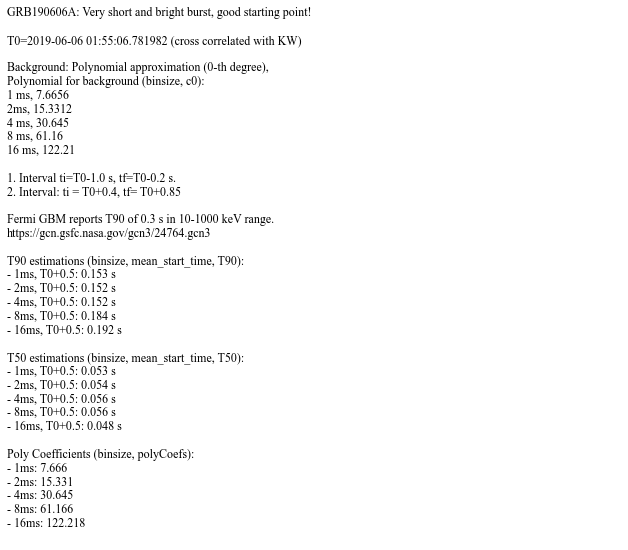

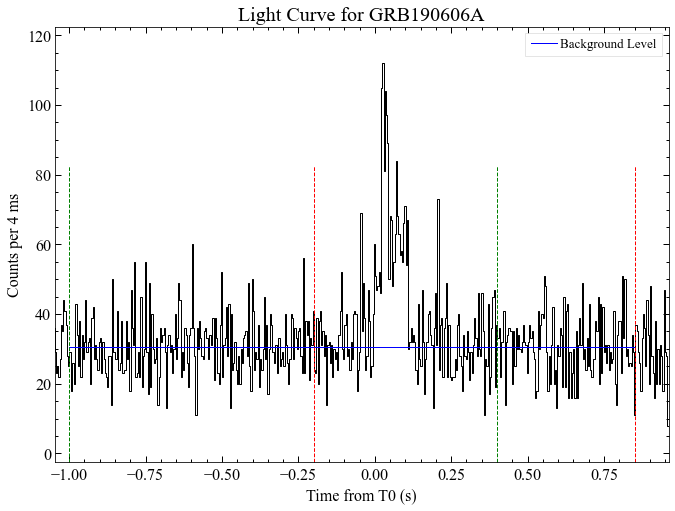

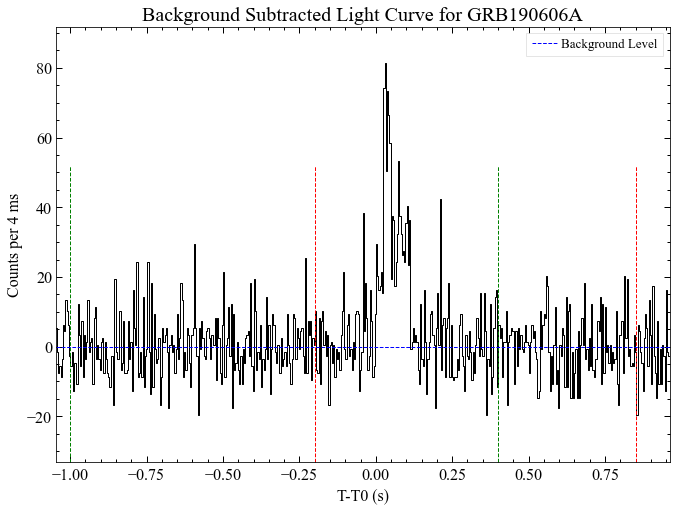

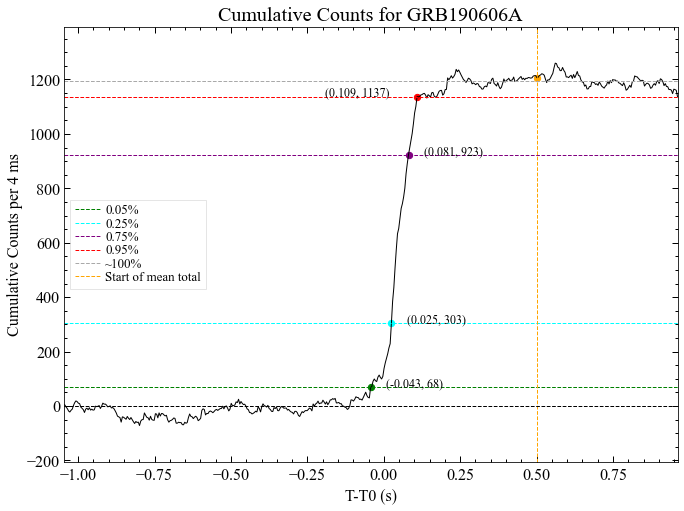

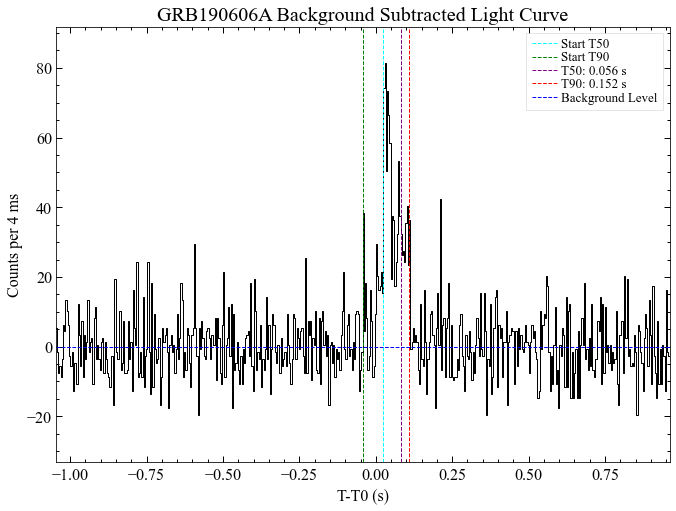

In [114]:
T90, T50, polyCoefs = estimate_duration('GRB190606A', 0.004, -0.5366225269343781, '2019-06-06T01:55:07.318605', bak_interval=[(-1, -0.2),(0.4,0.85)],
                                        mean_start_time=0.5, poly_degree=0, export=True,  info_text=info_GRB190606A)

## GRB 201227A
    -Difficult to calculate the background on the interval
        --> Check if ratemeter data is availible before current trigger burst
        
    -Background level is too high. See this before and after the inflection point / exponential
    
    -T90 reported by Fermi: 0.1 s (50-300 keV) => Suggesting to also calculate the backgorund after the burst
        --> Have implemented multiple interval for background estimation
    -

In [116]:
info_GRB201227A = "GRB 201227A: Short, bright, another good bright burst!\n\nT90 ends at significant count rate drop.\n\nBackground: Polynomial approximation (0-th degree), ti=- s, tf=- s.\n\nT90 estimations (binsize, mean_start_time, T90):\n- 1ms, 0.1: 0.106 s\n- 2ms, 0.1: 0.108 s\n- 4ms, 0.1: 0.108 s\n- 8ms, 0.1: 0.112 s\n- 16ms, 0.1: 0.112 s\n\nT50 estimations (binsize, mean_start_time, T50):\n- 1ms, 0.1: 0.022 s\n- 2ms, 0.1: 0.022 s\n- 4ms, 0.1: 0.02 s\n- 8ms, 0.1: 0.016 s\n- 16ms, 0.1: 0.016 s\n\nPolynomial for background (binsize, polyCoef):\n- 1ms: 2.572\n- 2ms: 5.135\n- 4ms: 10.278\n- 8ms: 20.569\n- 16ms: 41.089"

In [117]:
info_GRB201227A = "GRB 201227A: Short, bright, another good bright burst!\n\nT90 ends at significant count rate drop.\n\nBackground: Polynomial approximation (0-th degree), ti=- s, tf=- s.\n\nT90 estimations (binsize, mean_start_time, T90):\n"

# add T90, T50 and polyCoef estimations from the data dictionary
for binsize, values in data.items():
    T90 = values[0]
    T50 = values[1]
    polyCoef = values[2]
    
    info_GRB201227A += f"- {binsize.replace('binsize ', '')}s, 0.1: {T90.replace('T90 ', '')} s\n"
    
info_GRB201227A += "\nT50 estimations (binsize, mean_start_time, T50):\n"
for binsize, values in data.items():
    T50 = values[1]
    info_GRB201227A += f"- {binsize.replace('binsize ', '')}s, 0.1: {T50.replace('T50 ', '')} s\n"
    
info_GRB201227A += "\nPolynomial for background (binsize, polyCoef):\n"
for binsize, values in data.items():
    polyCoef = values[2]
    info_GRB201227A += f"- {binsize.replace('binsize ', '')}s: {polyCoef.replace('poly ', '')}\n"

In [ ]:
data = {}

for binsize in [0.001,0.002, 0.004, 0.008, 0.016]:
    T90,T50,polyCoefs = estimate_duration(GRB_id='GRB201227A', binsize=binsize,tlagg_asim=-0.531, T0='2020-12-27T15:14:06.853667', bak_interval=[(-0.95, -0.05),(0.1,0.95)], 
                        mean_start_time=0.1,poly_degree=0,export=False, info_text=None)
    data[f"binsize {binsize}"] = [f"T90 {round(T90,3)}", f"T50 {round(T50,3)}", f"poly {round(polyCoefs[0],3)}"]

T0 2020-12-27 15:14:06.322667, applied time lagg: -0.531 s
poly: [10.32723112]


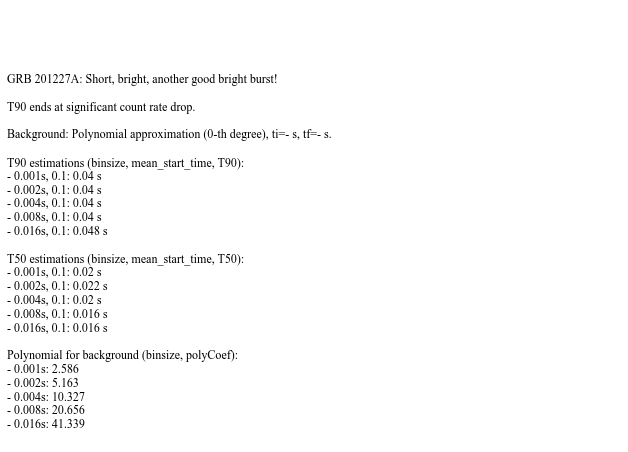

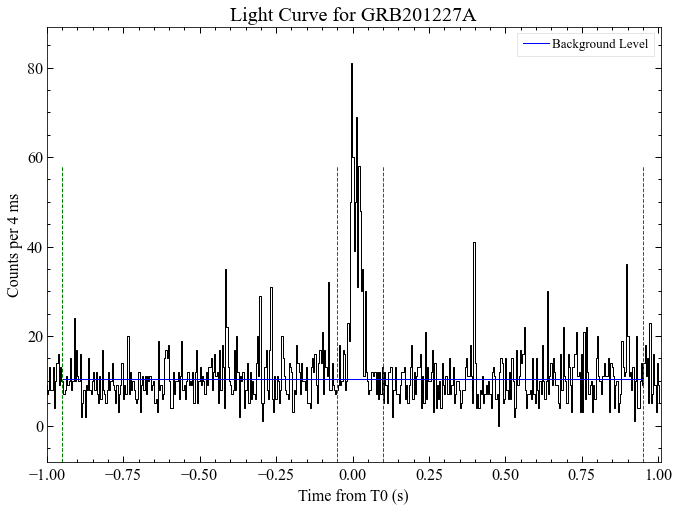

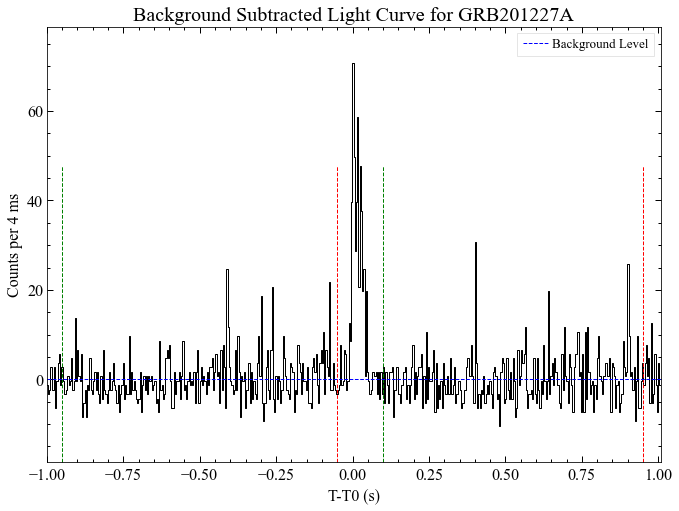

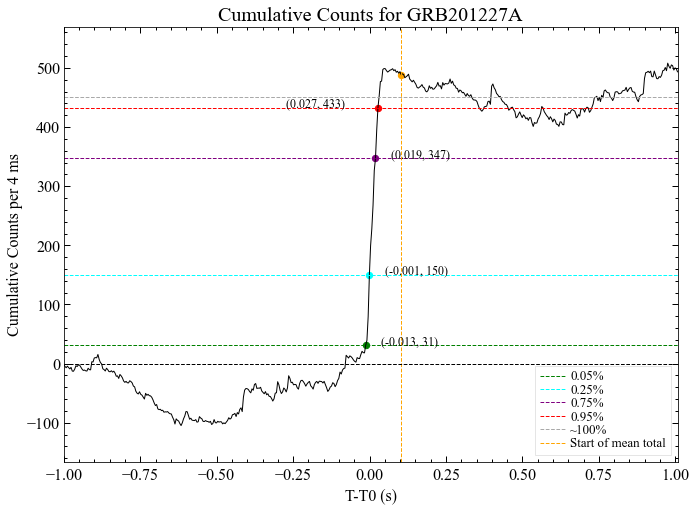

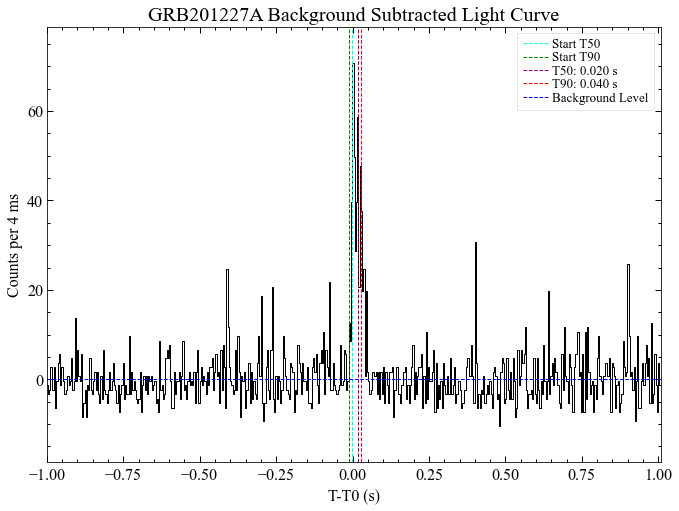

In [119]:
T90,T50,polyCoefs = estimate_duration(GRB_id='GRB201227A', binsize=0.004,tlagg_asim=-0.531, T0='2020-12-27T15:14:06.853667', bak_interval=[(-0.95, -0.05),(0.1,0.95)], 
                        mean_start_time=0.1,poly_degree=0,export=True, info_text=info_GRB201227A)

## GRB 181222B
    - Need to use the data provided by Andrey; previously used data from David
        --> Calculate tlagg_asim again from Andrey data
        
    -Having trouble using the GUI from Andrey. Installed new CDF patch (390) but having trouble with the spdfcdfread (line 601) file. 
        --> Anyway, can access the T0 from the previously extracted datafiles from Andrey.

In [9]:
info_GRB181222B = "GRB181222B: Short and bright burst. Precoursor starts at around T0=2018-12-22 20:11:36.197430 (cross correlated with KW) \n\n T90 starts at peak in the precursor and ends at the end of the burst. \n\n Background: Stable. Polynomial approximation (0-th degree). 1. interval ti=T0-0.85 s, tf=T0-0.25 s. \n 2. interval: ti= T0+0.45 s tf=T0+1.0 s \n\n Fermi GBM reports T90 of about 0.5 s (50-300 keV)\n https://gcn.gsfc.nasa.gov/gcn3/23551.gcn3 \n\nT90 estimations (binsize, Start time of the estimation of the mean total counts, T90):\n- 1ms, T0+0.5 s: 0.244 s\n- 2ms, - T0+0.5 s: 0.246 s\n- 4ms, - T0+0.5 s: 0.236 s\n- 8ms,  T0+0.5 s: 0.232 s\n- 16ms,  T0+0.5 s: 0.224 s\n\n T50 estimations (binsize, mean_start_time, T50):\n- 1ms, T0+0.5: 0.051 s\n- 2ms, T0+0.5: 0.052 s\n- 4ms, T0+0.5: 0.052 s\n- 8ms, T0+0.5: 0.048 s\n- 16ms, T0+0.5: 0.048 s"

In [121]:
info_GRB181222B = "GRB181222B: Short and bright burst. Precoursor starts at around T0=2018-12-22 20:11:36.197430 (cross correlated with KW) \n\n T90 starts at peak in the precursor and ends at the end of the burst. \n\n Background: Stable. Polynomial approximation (0-th degree). 1. interval ti=T0-0.85 s, tf=T0-0.25 s. \n 2. interval: ti= T0+0.45 s tf=T0+1.0 s \n\n Fermi GBM reports T90 of about 0.5 s (50-300 keV)\n https://gcn.gsfc.nasa.gov/gcn3/23551.gcn3 \n\nT90 estimations (binsize, Start time of the estimation of the mean total counts, T90):\n"

# add T90, T50 and polyCoef estimations from the data dictionary
for binsize, values in data.items():
    T90 = values[0]
    T50 = values[1]
    polyCoef = values[2]
    
    info_GRB181222B += f"- {binsize.replace('binsize ', '')}s, T0+0.5 s: {T90.replace('T90 ', '')} s\n"
    
info_GRB181222B += "\n T50 estimations (binsize, mean_start_time, T50):\n"
for binsize, values in data.items():
    T50 = values[1]
    info_GRB181222B += f"- {binsize.replace('binsize ', '')}s, T0+0.5: {T50.replace('T50 ', '')} s\n"

info_GRB181222B += "\nPolynomial for background (binsize, polyCoef):\n"
for binsize, values in data.items():
    polyCoef = values[2]
    info_GRB181222B += f"- {binsize.replace('binsize ', '')}s: {polyCoef.replace('poly ', '')}\n"

In [ ]:
data = {}

for binsize in [0.001,0.002, 0.004, 0.008, 0.016]:
    T90,T50,polyCoefs = estimate_duration(GRB_id='GRB181222B', binsize=binsize,tlagg_asim=-0.8540001094341279, T0='2018-12-22T20:11:37.051430',
                    bak_interval=[(-0.85, -0.25),(0.45,1.0)],mean_start_time=0.5,poly_degree=0, export=False, info_text=None)
    data[f"binsize {binsize}"] = [f"T90 {round(T90,3)}", f"T50 {round(T50,3)}", f"poly {round(polyCoefs[0],3)}"]

T0 2018-12-22 20:11:36.197430, applied time lagg: -0.854 s
poly: [43.53658537]


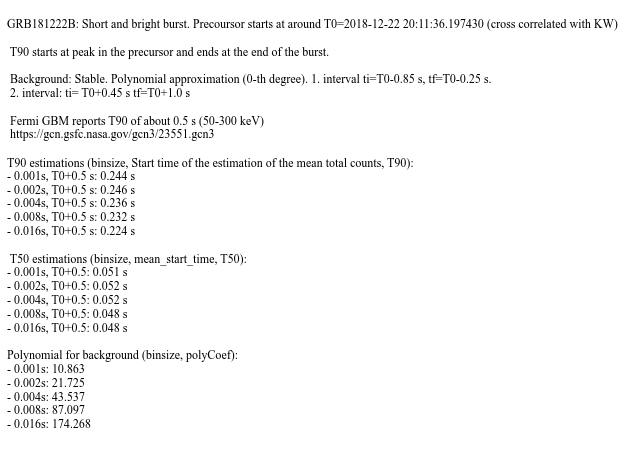

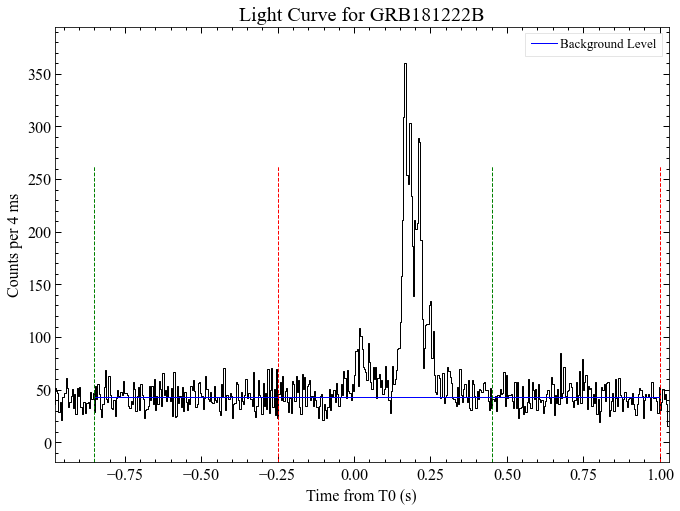

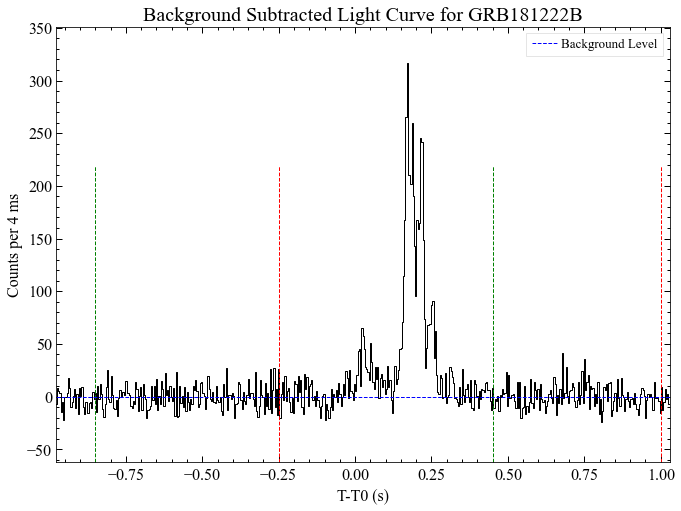

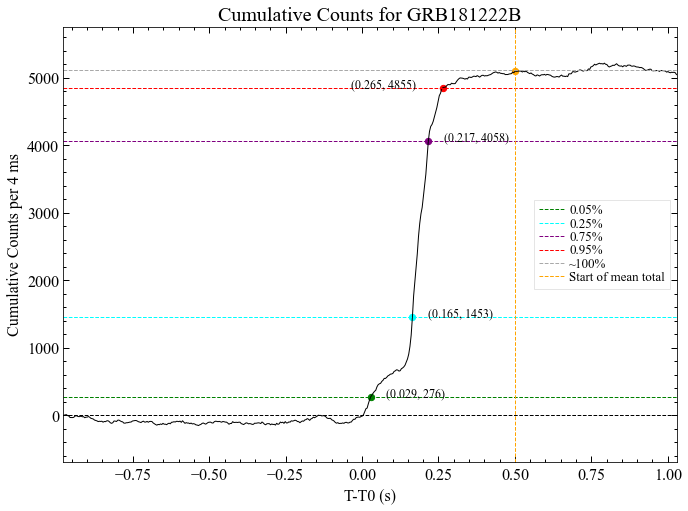

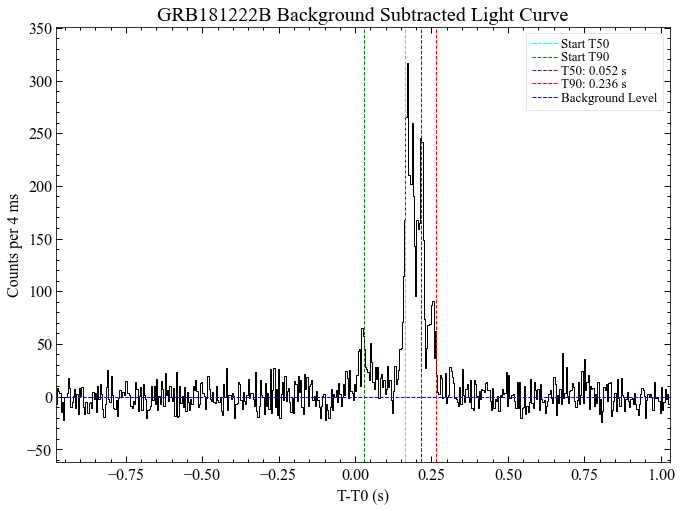

In [122]:
T90,T50,polyCoefs = estimate_duration(GRB_id='GRB181222B', binsize=0.004,tlagg_asim=-0.8540001094341279, T0='2018-12-22T20:11:37.051430',
                    bak_interval=[(-0.85, -0.25),(0.45,1.0)],mean_start_time=0.5,poly_degree=0, export=True, info_text=info_GRB181222B)

## GRB200521A

In [11]:
info_GRB200521A = "GRB 200521A: Relatively short burst, moderate count rate. \nT0=2020-05-21 12:16:39.630360 (cross correlated with KW) \n\n Background: Stable. Polynomial approximation (0-th degree). \n 1. interval ti=T0-0.90 s, tf=T0-0.10 s. \n 2. interval: ti= T0+0.40 s, tf=T0+1.0 s \n\n CALET GBM reports T90 and T50 durations measured by the SGM data are 0.240 +- 0.094 s and 0.104 +- 0.018 s (40-1000 keV), respectively.\n https://gcn.gsfc.nasa.gov/gcn3/27777.gcn3 \n\nT90 estimations (binsize, Start time of the estimation of the mean total counts, T90):\n- 1ms, T0+0.3 s: 0.173 s\n- 2ms, - T0+0.3 s: 0.174 s\n- 4ms, - T0+0.5 s: 0.172 s\n- 8ms,  T0+0.5 s: 0.168 s\n- 16ms,  T0+0.5 s: 0.176 s\n\n T50 estimations (binsize, mean start time, T50):\n- 1ms, T0+0.3 s: 0.075 s\n- 2ms, T0+0.3 s: 0.074 s\n- 4ms, T0+0.3 s: 0.076 s\n- 8ms, T0+0.3 s: 0.072 s\n- 16ms, T0+0.3 s: 0.08 s"

In [ ]:
data = {}

for binsize in [0.001,0.002, 0.004, 0.008, 0.016]:
    T90,T50,polyCoefs = estimate_duration(GRB_id='GRB200521A', binsize=binsize,tlagg_asim=-0.814, T0='2020-05-21T12:16:40.444360',
                    bak_interval=[(-0.9, -0.1),(0.4,1.0)],mean_start_time=0.3,poly_degree=0, export=False, info_text=None)
    data[f"binsize {binsize}"] = [f"T90 {round(T90,3)}", f"T50 {round(T50,3)}", f"poly {round(polyCoefs[0],3)}"]

In [124]:
data

{'binsize 0.001': ['T90 0.173', 'T50 0.075', 'poly 2.916'],
 'binsize 0.002': ['T90 0.174', 'T50 0.074', 'poly 5.833'],
 'binsize 0.004': ['T90 0.172', 'T50 0.076', 'poly 11.677'],
 'binsize 0.008': ['T90 0.168', 'T50 0.072', 'poly 23.371'],
 'binsize 0.016': ['T90 0.176', 'T50 0.08', 'poly 46.851']}

In [125]:
info_GRB200521A = "GRB 200521A: Relatively short burst, moderate count rate. \nT0=2020-05-21 12:16:39.630360 (cross correlated with KW) \n\n Background: Stable. Polynomial approximation (0-th degree). \n 1. interval ti=T0-0.90 s, tf=T0-0.10 s. \n 2. interval: ti= T0+0.40 s, tf=T0+1.0 s \n\n CALET GBM reports T90 and T50 durations measured by the SGM data are 0.240 +- 0.094 s and 0.104 +- 0.018 s (40-1000 keV), respectively.\n https://gcn.gsfc.nasa.gov/gcn3/27777.gcn3 \n\nT90 estimations (binsize, Start time of the estimation of the mean total counts, T90):\n"

# add T90, T50 and polyCoef estimations from the data dictionary
for binsize, values in data.items():
    T90 = values[0]
    T50 = values[1]
    polyCoef = values[2]
    
    info_GRB200521A += f"- {binsize.replace('binsize ', '')}s, T0+0.3 s: {T90.replace('T90 ', '')} s\n"
    
info_GRB200521A += "\n T50 estimations (binsize, mean_start_time, T50):\n"
for binsize, values in data.items():
    T50 = values[1]
    info_GRB200521A += f"- {binsize.replace('binsize ', '')}s, T0+0.3 s: {T50.replace('T50 ', '')} s\n"

info_GRB200521A += "\nPolynomial for background (binsize, polyCoef):\n"
for binsize, values in data.items():
    polyCoef = values[2]
    info_GRB200521A += f"- {binsize.replace('binsize ', '')}s: {polyCoef.replace('poly ', '')}\n"

T0 2020-05-21 12:16:39.630360, applied time lagg: -0.814 s
poly: [11.67714286]


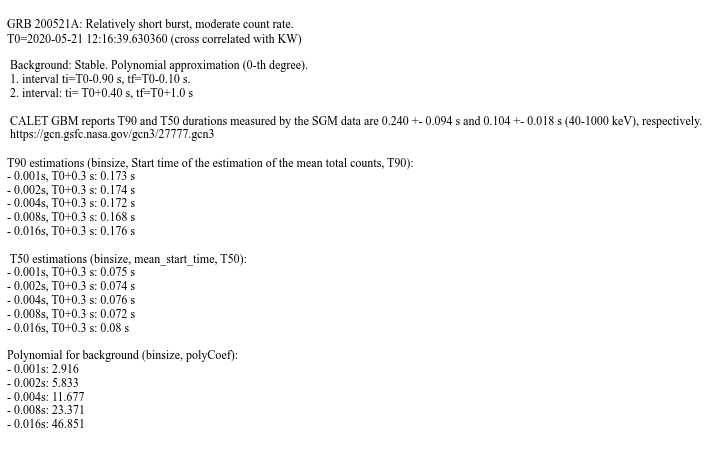

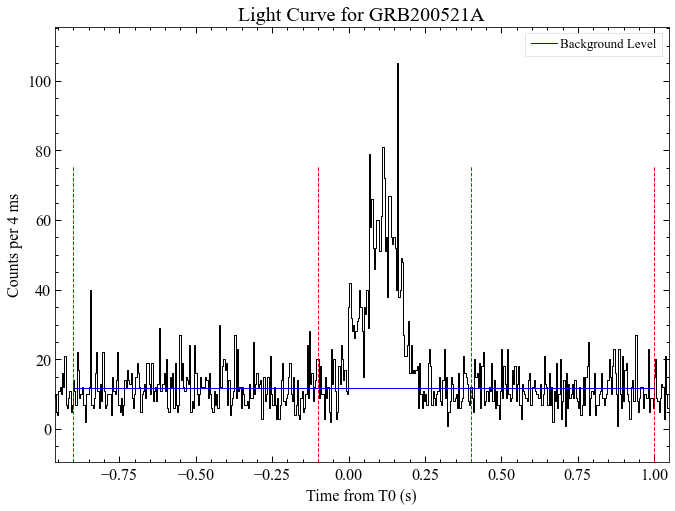

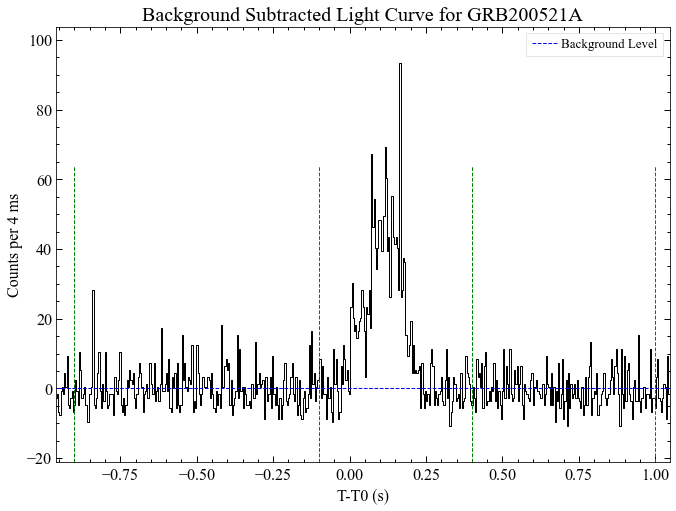

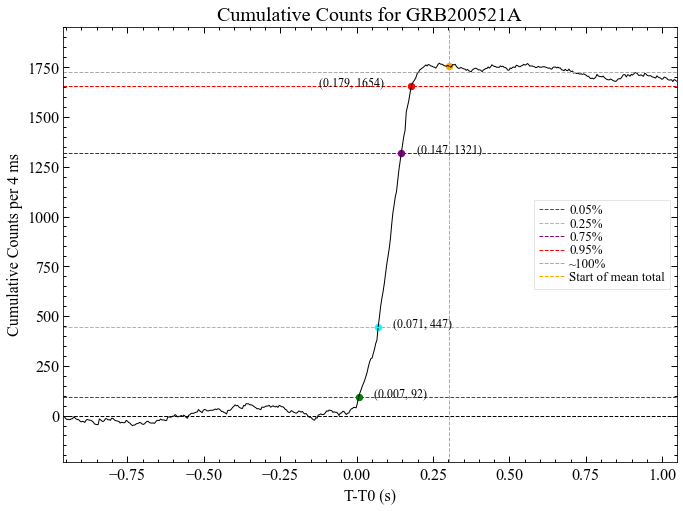

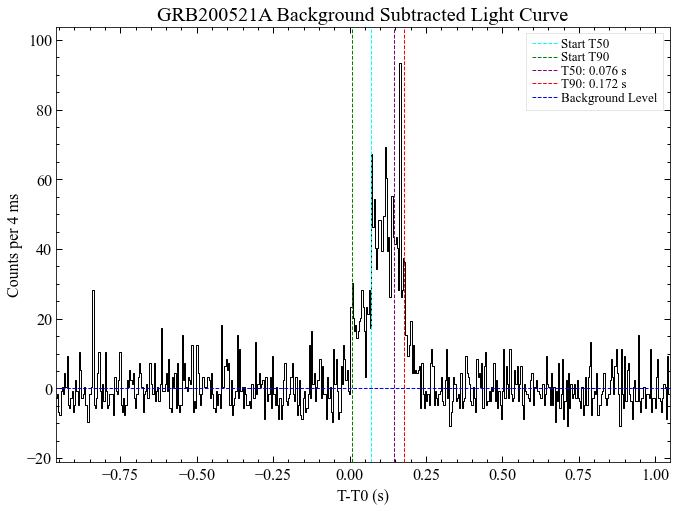

In [127]:
T90,T50,polyCoefs = estimate_duration(GRB_id='GRB200521A', binsize=0.004,tlagg_asim=-0.814, T0='2020-05-21T12:16:40.444360',
                    bak_interval=[(-0.9, -0.1),(0.4,1.0)],mean_start_time=0.3,poly_degree=0, export=True, info_text=info_GRB200521A)

## GRB 190206A

In [58]:
info_GRB190206A = "GRB 190206A: Very short burst, high count rate, good signal to noise ratio. \nT0=2019-02-06 03:49:27.717670 (cross correlated with KW) \n\n Background: Very stable. Polynomial approximation (1-th degree) works best due to rather long background interval. \n 1. interval ti=T0-0.90 s, tf=T0-0.30 s. \n 2. interval: ti= T0+0.30 s, tf=T0+0.90 s \n\n AstroSat CZTI detection reports T90 of 0.94 s in 40-200 keV range\n https://gcn.gsfc.nasa.gov/gcn3/23892.gcn3 \n\n T90 estimations (binsize, Start time of the estimation of the mean total counts, T90):\n- 1ms, T0+0.2 s: 0.036 s\n- 2ms, - T0+0.2 s: 0.036 s\n- 4ms, - T0+0.2 s: 0.036 s\n- 8ms,  T0+0.2 s: 0.04 s\n- 16ms,  T0+0.2 s: 0.304 s\n\n T50 estimations (binsize, mean start time, T50):\n- 1ms, T0+0.2 s: 0.01 s\n- 2ms, T0+0.2 s: 0.01 s\n- 4ms, T0+0.2 s: 0.008 s\n- 8ms, T0+0.2 s: 0.008 s\n- 16ms, T0+0.2 s: < binsize"

In [ ]:
data = {}

for binsize in [0.001,0.002, 0.004, 0.008, 0.016]:
    T90,T50,polyCoefs = estimate_duration(GRB_id='GRB190206A', binsize=binsize,tlagg_asim=-0.2955, T0='2019-02-06T03:49:28.013170',
                    bak_interval=[(-0.9, -0.25),(0.25,0.9)],mean_start_time=0.1,poly_degree=1, export=False, info_text=None)
    data[f"binsize {binsize}"] = [f"T90 {round(T90,3)}", f"T50 {round(T50,3)}", f"poly {np.round(polyCoefs,3)}"]

In [129]:
data

{'binsize 0.001': ['T90 0.03', 'T50 0.01', 'poly [11.268  0.255]'],
 'binsize 0.002': ['T90 0.028', 'T50 0.01', 'poly [22.531  0.551]'],
 'binsize 0.004': ['T90 0.032', 'T50 0.008', 'poly [45.029  1.106]'],
 'binsize 0.008': ['T90 0.032', 'T50 0.008', 'poly [90.138  2.175]'],
 'binsize 0.016': ['T90 0.032', 'T50 0.0', 'poly [179.815   4.333]']}

In [130]:
info_GRB190206A = "GRB 190206A: Very short burst, high count rate, good signal to noise ratio. \nT0=2019-02-06 03:49:27.717670 (cross correlated with KW) \n\n Background: Very stable. Polynomial approximation (1-th degree) works best due to rather long background interval. \n 1. interval ti=T0-0.90 s, tf=T0-0.30 s. \n 2. interval: ti= T0+0.30 s, tf=T0+0.90 s \n\n AstroSat CZTI detection reports T90 of 0.94 s in 40-200 keV range\n https://gcn.gsfc.nasa.gov/gcn3/23892.gcn3 \n\n T90 estimations (binsize, Start time of the estimation of the mean total counts, T90):\n"

# add T90, T50 and polyCoef estimations from the data dictionary
for binsize, values in data.items():
    T90 = values[0]
    T50 = values[1]
    polyCoef = values[2]
    
    info_GRB190206A += f"- {binsize.replace('binsize ', '')}s, T0+0.2 s: {T90.replace('T90 ', '')} s\n"
    
info_GRB190206A += "\n T50 estimations (binsize, mean_start_time, T50):\n"
for binsize, values in data.items():
    T50 = values[1]
    info_GRB190206A += f"- {binsize.replace('binsize ', '')}s, T0+0.2 s: {T50.replace('T50 ', '')} s\n"

info_GRB190206A += "\nPolynomial for background (binsize, polyCoef):\n"
for binsize, values in data.items():
    polyCoef = values[2]
    info_GRB190206A += f"- {binsize.replace('binsize ', '')}s: {polyCoef.replace('poly ', '')}\n"


In [91]:
info_GRB190206A = 'GRB 190206A: Very short burst, high count rate, good signal to noise ratio. \nT0=2019-02-06 03:49:27.717670 (cross correlated with KW) \n\n Background: Very stable. Polynomial approximation (1-th degree) works best due to rather long background interval. \n 1. interval ti=T0-0.90 s, tf=T0-0.30 s. \n 2. interval: ti= T0+0.30 s, tf=T0+0.90 s \n\n AstroSat CZTI detection reports T90 of 0.94 s in 40-200 keV range\n https://gcn.gsfc.nasa.gov/gcn3/23892.gcn3 \n\n T90 estimations (binsize, Start time of the estimation of the mean total counts, T90):\n- 0.001s, T0+0.2 s: 0.03 s\n- 0.002s, T0+0.2 s: 0.028 s\n- 0.004s, T0+0.2 s: 0.032 s\n- 0.008s, T0+0.2 s: 0.032 s\n- 0.016s, T0+0.2 s: 0.032 s\n\n T50 estimations (binsize, mean_start_time, T50):\n- 0.001s, T0+0.2 s: 0.01 s\n- 0.002s, T0+0.2 s: 0.01 s\n- 0.004s, T0+0.2 s: 0.008 s\n- 0.008s, T0+0.2 s: 0.008 s\n- 0.016s, T0+0.2 s: <binsize \n\nPolynomial for background (binsize, polyCoef):\n- 0.001s: [11.268  0.255]\n- 0.002s: [22.531  0.551]\n- 0.004s: [45.029  1.106]\n- 0.008s: [90.138  2.175]\n- 0.016s: [179.815   4.333]\n'

T0 2019-02-06 03:49:27.717670, applied time lagg: -0.2955 s
poly: [22.53054601  0.55116784]


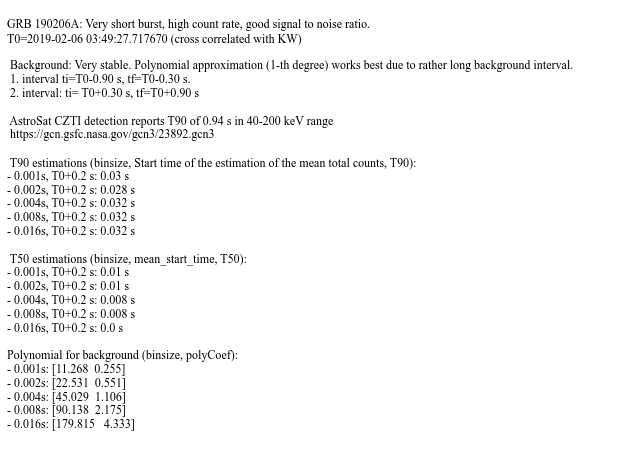

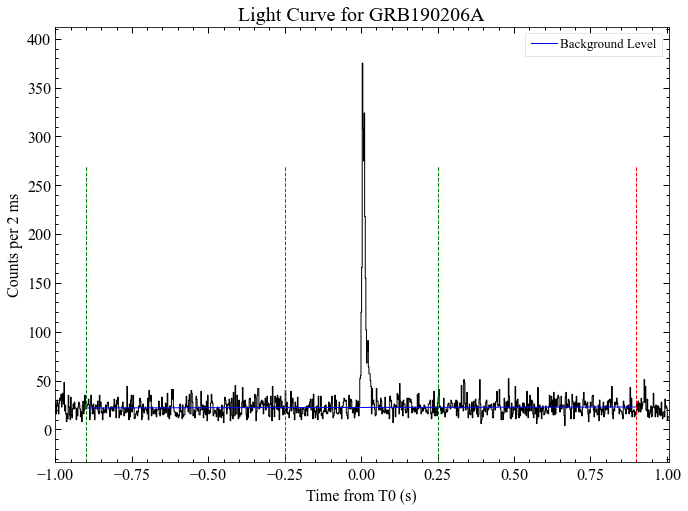

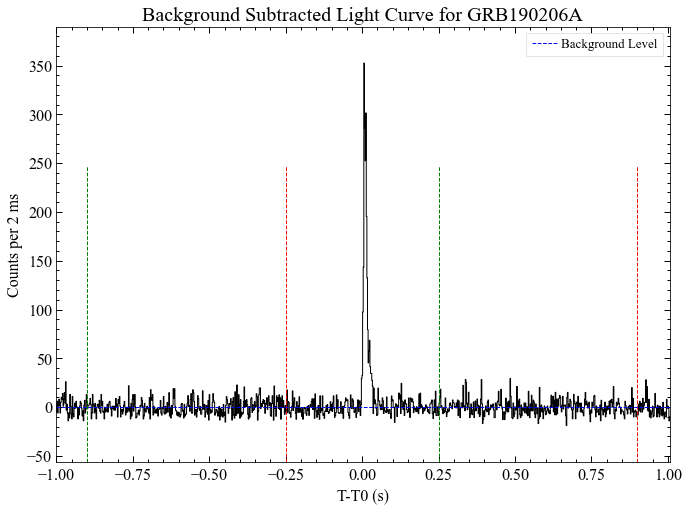

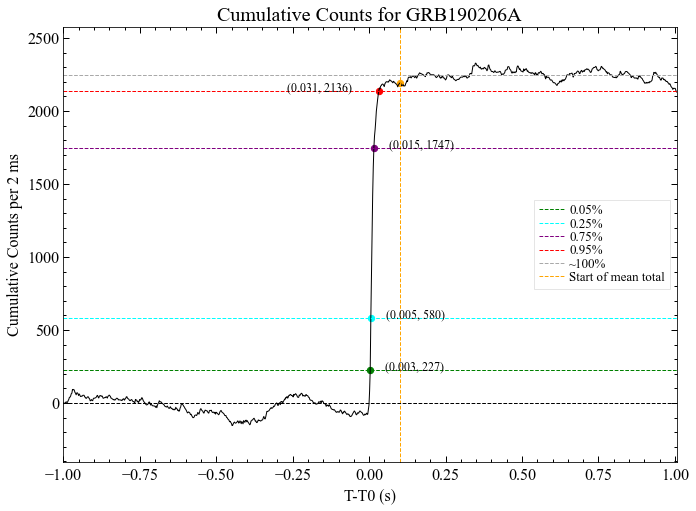

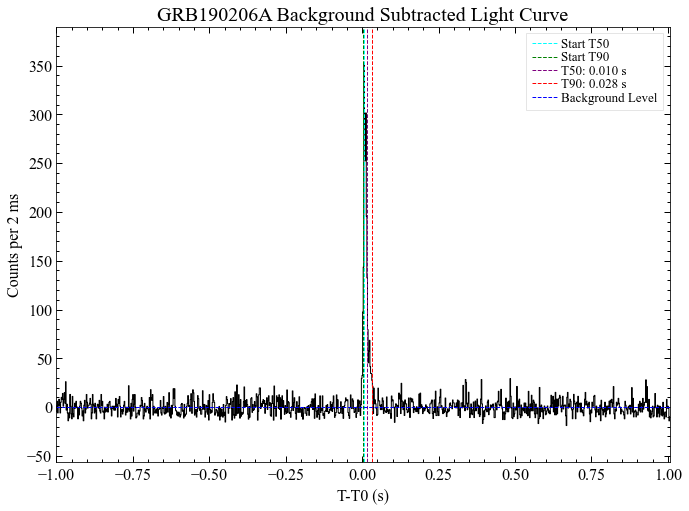

In [131]:
T90,T50,polyCoefs = estimate_duration(GRB_id='GRB190206A', binsize=0.002,tlagg_asim=-0.2955, T0='2019-02-06T03:49:28.013170',
                    bak_interval=[(-0.9, -0.25),(0.25,0.9)],mean_start_time=0.1,poly_degree=1, export=True, info_text=info_GRB190206A)

## GRB 190305A

T0 2019-03-05 13:05:20.870702, applied time lagg: 0.51506 s
poly: [28.04761905]


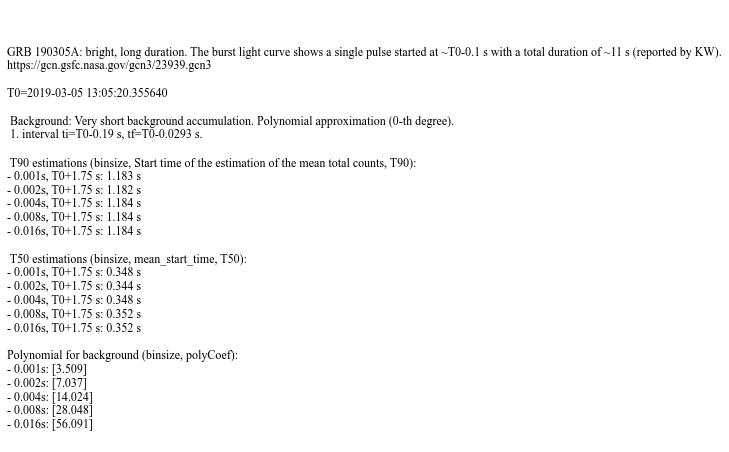

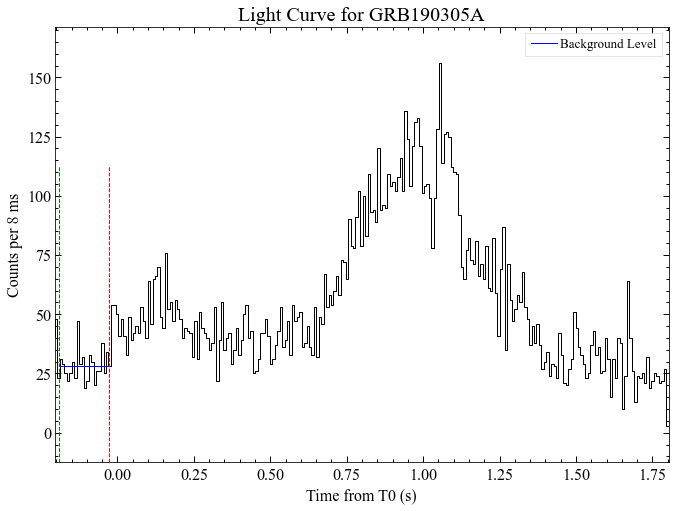

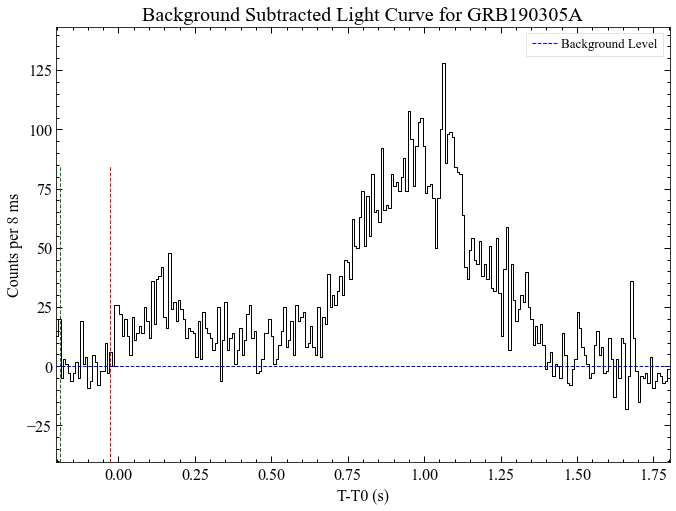

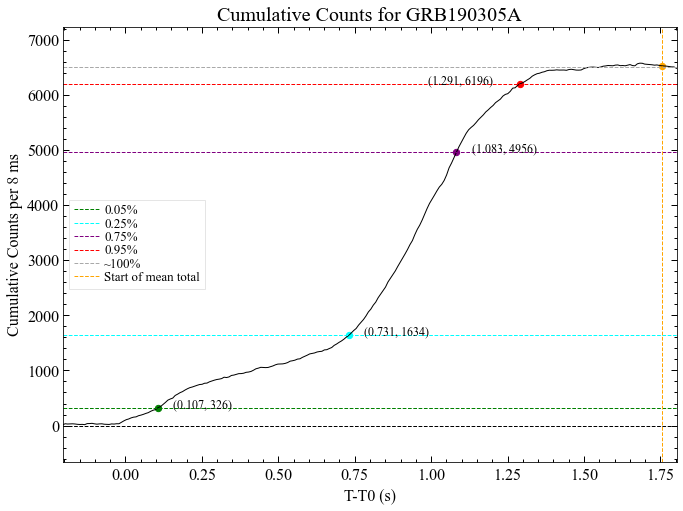

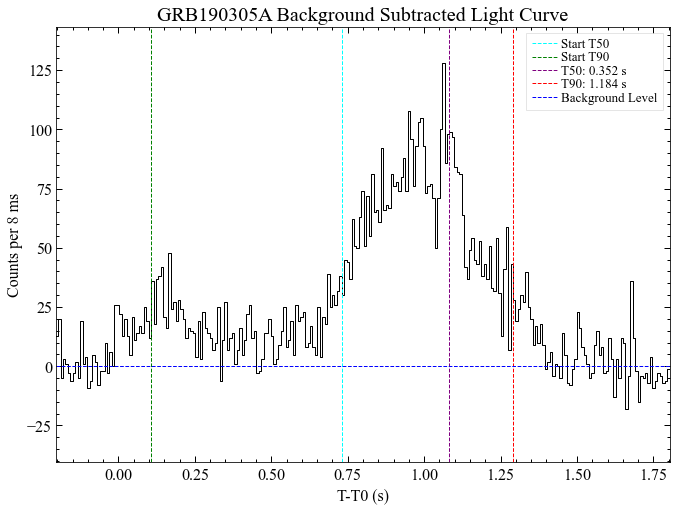

In [134]:
info_GRB190305A = 'GRB 190305A: bright, long duration. The burst light curve shows a single pulse started at ~T0-0.1 s with a total duration of ~11 s (reported by KW).\nhttps://gcn.gsfc.nasa.gov/gcn3/23939.gcn3 \n\nT0=2019-03-05 13:05:20.355640 \n\n Background: Very short background accumulation. Polynomial approximation (0-th degree). \n 1. interval ti=T0-0.19 s, tf=T0-0.0293 s.\n\n T90 estimations (binsize, Start time of the estimation of the mean total counts, T90):\n- 0.001s, T0+1.75 s: 1.183 s\n- 0.002s, T0+1.75 s: 1.182 s\n- 0.004s, T0+1.75 s: 1.184 s\n- 0.008s, T0+1.75 s: 1.184 s\n- 0.016s, T0+1.75 s: 1.184 s\n\n T50 estimations (binsize, mean_start_time, T50):\n- 0.001s, T0+1.75 s: 0.348 s\n- 0.002s, T0+1.75 s: 0.344 s\n- 0.004s, T0+1.75 s: 0.348 s\n- 0.008s, T0+1.75 s: 0.352 s\n- 0.016s, T0+1.75 s: 0.352 s\n\nPolynomial for background (binsize, polyCoef):\n- 0.001s: [3.509]\n- 0.002s: [7.037]\n- 0.004s: [14.024]\n- 0.008s: [28.048]\n- 0.016s: [56.091]\n'
T90,T50,polyCoefs = estimate_duration(GRB_id='GRB190305A', binsize=0.008,tlagg_asim=0.5150625, T0='2019-03-05T13:05:20.355640',
                    bak_interval=[(-0.19, -0.0293)],mean_start_time=1.75,poly_degree=0, export=True, info_text=info_GRB190305A)

In [ ]:
data = {}

for binsize in [0.001,0.002, 0.004, 0.008, 0.016]:
    T90,T50,polyCoefs = estimate_duration(GRB_id='GRB190305A', binsize=binsize,tlagg_asim=0.5150625, T0='2019-03-05T13:05:20.355640',
                    bak_interval=[(-0.19, -0.0293)],mean_start_time=1.75,poly_degree=0, export=False, info_text=None)
    data[f"binsize {binsize}"] = [f"T90 {round(T90,3)}", f"T50 {round(T50,3)}", f"poly {np.round(polyCoefs,3)}"]

In [133]:
info_GRB190305A = "GRB 190305A: Data specifics not provided. \nT0=2019-03-05 13:05:20.355640 \n\n Background: Details not provided. Polynomial approximation (0-th degree). \n 1. interval ti=T0-0.19 s, tf=T0-0.0293 s. \n\n No detection report provided. \n\n T90 estimations (binsize, Start time of the estimation of the mean total counts, T90):\n"

# add T90, T50 and polyCoef estimations from the data dictionary
for binsize, values in data.items():
    T90 = values[0]
    T50 = values[1]
    polyCoef = values[2]
    
    info_GRB190305A += f"- {binsize.replace('binsize ', '')}s, T0+1.75 s: {T90.replace('T90 ', '')} s\n"
    
info_GRB190305A += "\n T50 estimations (binsize, mean_start_time, T50):\n"
for binsize, values in data.items():
    T50 = values[1]
    info_GRB190305A += f"- {binsize.replace('binsize ', '')}s, T0+1.75 s: {T50.replace('T50 ', '')} s\n"

info_GRB190305A += "\nPolynomial for background (binsize, polyCoef):\n"
for binsize, values in data.items():
    polyCoef = values[2]
    info_GRB190305A += f"- {binsize.replace('binsize ', '')}s: {polyCoef.replace('poly ', '')}\n"